# [MICRO-452:] Project Report - Groupe 28
**Authors:** Celest Angela Tjong, Adrien Louis Baptiste Dupont, Luca Sidoti Pinto, Didier Henri Neuenschwander
**Supervisors:** Prof. Francesco Mondada
Date: 17 Novembre 2023

[MICRO-452]: **to be changed**

<span style="color:red; font-size:40px;">use as few personal pronouns as possible (we, our, etc.
)

# Table of Contents
* [1. Introduction](#introduction)
* [2. Vision](#vision)
    * [2.1. Subsection 1](#vision-subsection-1)
    * [2.2. Subsection 2](#vision-subsection-2)
* [3. Global Navigation](#global-navigation)
* [4. Filtering](#filtering)
* [5. Local Navigation](#local-navigation)
* [6. Conclusion](#conclusion)
lusion)
clusion)
usion)


## 1 Introduction
<a id="introduction"></a>

## 2 Vision
<a id="vision"></a>
https://docs.opencv.org/4.x/df/d9d/tutorial_py_colorspaces.html

### Vision Subsection 1
<a id="Vision-subsection-1"></a>
**Ask to TA if we have to describe every function used in the notebook?**







In [96]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import time

# Define color thresholds for red and green in HSV
# Note: these thresholds may need to be adjusted for your specific image conditions
lower_red_bound = np.array([120, 100, 70])
upper_red_bound = np.array([255, 255, 255])
lower_green_bound = np.array([60, 50, 100])
upper_green_bound = np.array([100, 255, 255])
lower_yellow_bound = np.array([0, 60, 140])
upper_yellow_bound = np.array([40, 105, 255])
lower_black_bound = np.array([0, 0, 0])
upper_black_bound = np.array([180, 180, 50])

In [142]:
# Import tdmclient Notebook environment:
#import tdmclient.notebook
#await tdmclient.notebook.start()
# forward
#motor_left_target= 100
#motor_right_target= 100

NodeLockError: Node lock error (current status: busy)

In [145]:
"""
video_capture = cv2.VideoCapture(0, cv2.CAP_DSHOW)

video_capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1080)
video_capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
# Obtenir les dimensions de la frame
frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Définir le codec et créer un objet VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (frame_width, frame_height))

# Enregistrer la vidéo
while video_capture.isOpened():
    ret, frame = video_capture.read()
    if ret:
        # Écrire la frame dans le fichier
        out.write(frame)

        # Afficher la frame (si vous voulez voir le flux en temps réel)
        cv2.imshow('Frame', frame)

        # Quitter avec la touche 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Libérer les ressources
video_capture.release()
out.release()
cv2.destroyAllWindows()
"""


"\nvideo_capture = cv2.VideoCapture(0, cv2.CAP_DSHOW)\n\nvideo_capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1080)\nvideo_capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)\n# Obtenir les dimensions de la frame\nframe_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))\nframe_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))\n\n# Définir le codec et créer un objet VideoWriter\nfourcc = cv2.VideoWriter_fourcc(*'XVID')\nout = cv2.VideoWriter('output.avi', fourcc, 20.0, (frame_width, frame_height))\n\n# Enregistrer la vidéo\nwhile video_capture.isOpened():\n    ret, frame = video_capture.read()\n    if ret:\n        # Écrire la frame dans le fichier\n        out.write(frame)\n\n        # Afficher la frame (si vous voulez voir le flux en temps réel)\n        cv2.imshow('Frame', frame)\n\n        # Quitter avec la touche 'q'\n        if cv2.waitKey(1) & 0xFF == ord('q'):\n            break\n    else:\n        break\n\n# Libérer les ressources\nvideo_capture.release()\nout.release()\ncv2.dest

In [137]:


# Define a function to detect circles of a specific color
def detect_color_circle(image, lower_color_bound, upper_color_bound):
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create a mask for the specified color
    mask = cv2.inRange(hsv, lower_color_bound, upper_color_bound)

    # Apply the mask to the original image
    color_only = cv2.bitwise_and(image, image, mask=mask)

    # Convert to grayscale for circle detection
    gray = cv2.cvtColor(color_only, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection to help with circle detection
    edges = cv2.Canny(gray, 100, 200)

    # Use Hough Transform to detect circles
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 20,
                           param1=40, param2=15, minRadius=10, maxRadius=50)
    
    # If circles are detected, return the list of circles with x, y coordinates and radius
    if circles is not None:
        # Convert the (1, N, 3) array to (N, 3)
        circles = np.uint16(np.around(circles[0, :]))          
        return [(circle[0], circle[1], circle[2]) for circle in circles]
    else:
        return []
    
            




In [ ]:

def create_obstacle_mask(image, contours, kernel_size):
    """
    Create a mask with zeros in the areas inside the dilated contours.

    :param image: Input image.
    :param contours: Contours to dilate and fill in the mask.
    :param kernel_size: Size of the kernel used for dilation.
    :return: Mask with zeros inside the dilated contours and ones elsewhere.
    """
    # Create an empty mask of the same size as the image
    h, w = image.shape[:2]
    mask = np.ones((h, w), dtype=np.uint8)

    # Perform dilation to increase the size of the black regions
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    for contour in contours:
        # Create an individual mask for each contour
        contour_mask = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(contour_mask, [contour], 255)
        contour_mask = cv2.dilate(contour_mask, kernel, iterations=1)
        
        # Combine the individual mask with the global mask
        mask = cv2.bitwise_and(mask, cv2.bitwise_not(contour_mask))

        #also add the contours
        # Let's create a border around the image
        border_size = 50
        border_color = [0, 0, 0]  # Black border
        # Use cv2.copyMakeBorder to add a border around the image
        mask_with_border = cv2.copyMakeBorder(mask, border_size, border_size, border_size, border_size,
                                           cv2.BORDER_CONSTANT, value=border_color)
    
    return mask_with_border


# Now you have a mask with zeros in the obstacle areas and ones elsewhere
# You can return this mask from your function or process it further as needed


In [98]:


def detect_obstacle_contours(image, area_threshold, kernel_size):
    """
    Detects and dilates obstacle contours in the given image.
    :param image: Input image.
    :param area_threshold: Area threshold for filtering contours.
    :param kernel_size: Size of the kernel used for dilation.
    :return: Image with obstacle contours drawn.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask_black = cv2.inRange(hsv, lower_black_bound, upper_black_bound)
    contours, _ = cv2.findContours(mask_black, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > area_threshold]
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask_dilated = cv2.dilate(mask_black, kernel, iterations=1)
    dilated_contours, _ = cv2.findContours(mask_dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    filtered_dilated_contours = [cnt for cnt in dilated_contours if cv2.contourArea(cnt) > area_threshold+1000]
    contour_image = image.copy()
    cv2.drawContours(contour_image, filtered_contours, -1, (0, 255, 0), 2)
    cv2.drawContours(contour_image, filtered_dilated_contours, -1, (0, 0, 255), 2)
    return contour_image, filtered_contours, filtered_dilated_contours


In [123]:
def create_obstacle_matrix(image, dilated_contours):
    height, width = image.shape[:2]
    obstacle_matrix = np.ones((height, width), dtype=np.uint8)

    for contour in dilated_contours:
        # Remplir chaque contour dilaté avec 0 (obstacle)
        cv2.fillPoly(obstacle_matrix, [contour], 0)

    return obstacle_matrix


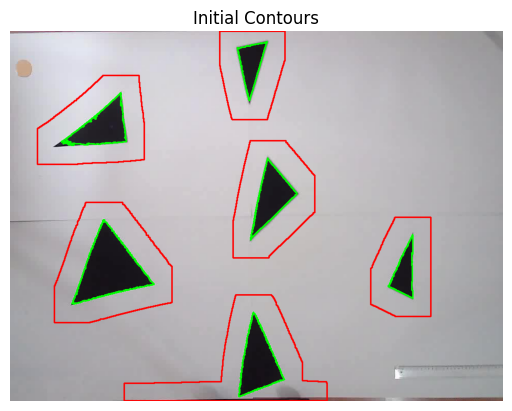

KeyboardInterrupt: 

In [146]:

# Chemin du fichier vidéo enregistré
video_path = 'output.avi'

# Ouvrir le fichier vidéo
video_capture = cv2.VideoCapture(video_path)

# Assurez-vous que le fichier vidéo s'ouvre correctement
if not video_capture.isOpened():
    print("Erreur : Impossible d'ouvrir le fichier vidéo.")
    exit()
#video_capture = cv2.VideoCapture(0, cv2.CAP_DSHOW)

video_capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1080)
video_capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
window_name = 'Robot Detection'
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)

# Redimensionner la fenêtre (largeur, hauteur)
cv2.resizeWindow(window_name, 540, 360)  # Réduire de moitié par exemple

# Initial detection of obstacles
ret, initial_frame = video_capture.read()
if ret:
     contour_image = detect_obstacle_contours(initial_frame, 2000, 70)
     global_obstacle = create_obstacle_matrix(initial_frame, contour_image[2])
     plt.imshow(cv2.cvtColor(contour_image[0], cv2.COLOR_BGR2RGB))
     plt.title('Initial Contours')
     plt.axis('off')
     plt.show()
     if yellow_circles:
    # Stocker les coordonnées du premier cercle jaune détecté
        yellow_circle_coords = yellow_circles[0]

# Robot update frequency (10 Hz)
update_rate = 0.1  # 10 times per second

try:
    while True:
        start_time = time.time()
        
        # Capture frame-by-frame
        ret, frame = video_capture.read()
        if not ret:
            break

        # Mettre à jour les contours d'obstacle pour la frame actuelle
 
        # Detect red and green circles
        red_circles = detect_color_circle(frame, lower_red_bound, upper_red_bound)
        green_circles = detect_color_circle(frame, lower_green_bound, upper_green_bound)

        
        if yellow_circles:
            x, y, r = yellow_circles[0] #coordinate of the goal*********************************************************
            cv2.circle(frame, (x, y), r, (0, 255, 255), 3) # Dessiner les cercles jaunes

            
        if red_circles and green_circles:
                    if len(red_circles) >= 2:
                        # Calculate the midpoint between the centers of the red circles
                        midpoint = ((red_circles[0][0] + red_circles[1][0]) // 2,
                        (red_circles[0][1] + red_circles[1][1]) // 2)
                        # Calculer le vecteur directionnel
                        direction = np.array([midpoint[0] - green_circles[0][0], midpoint[1] - green_circles[0][1]])
                    
                        # Normaliser et allonger le vecteur
                        length = 100  # Longueur supplémentaire
                        direction = direction / np.linalg.norm(direction) * length
                    
                        # Calculer le nouveau point d'arrivée
                        new_endpoint = (int(green_circles[0][0] + direction[0]), int(green_circles[0][1] + direction[1]))
                    
                        # Dessiner la flèche allongée
                        cv2.arrowedLine(frame, green_circles[0][:2], new_endpoint, (0, 0, 0), 3)

                        # Calculate the angle of orientation with respect to the x-axis
                        dx = green_circles[0][0] - midpoint[0]
                        dy = green_circles[0][1] - midpoint[1]
                        angle = math.atan2(dy, dx)
                        angle_degrees = math.degrees(angle)
                        robot_vector = (midpoint[0], midpoint[1], angle_degrees) #information of the robot
                        # Optionally, display the angle
                        cv2.putText(frame, f'Angle: {angle_degrees:.2f} degrees', (10, 30), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                     
                        cv2.putText(frame, f'Midpoint: ({midpoint[0]}, {midpoint[1]})', (10, 700),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            
        cv2.drawContours(frame, contour_image[1], -1, (0, 255, 0), 2)
        cv2.drawContours(frame, contour_image[2], -1, (0, 0, 255), 2)
        # Dimensions de la frame
        # Dimensions de la frame
        height, width = frame.shape[:2]

        # Coordonnées du point de départ du repère (bas droit de l'image)
        origin_x, origin_y = width - 150, height - 70  # Ajustement pour une longueur de 100
        # Dessiner l'axe X
        cv2.line(frame, (origin_x, origin_y), (origin_x + 100, origin_y), (0, 0, 255), 2)
        # Dessiner l'axe Y 
        cv2.line(frame, (origin_x, origin_y), (origin_x, origin_y - 100), (0, 255, 0), 2)
        # Marquer la longueur sur l'axe X
        cv2.putText(frame, "100", (origin_x + 100, origin_y + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 2)
        # Marquer la longueur sur l'axe Y
        cv2.putText(frame, "100", (origin_x - 30, origin_y - 100), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 255), 2)
        cv2.putText(frame, f'({origin_x}, {origin_y})', (origin_x-200, origin_y-10),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2) #environ 14cm pour 100pixcel
        # ... (le reste de votre code pour afficher la frame)
        # Display the resulting frame
        cv2.imshow('Robot Detection', frame)

        # Pause to maintain the update frequency
        time_to_wait = max(int((start_time + update_rate - time.time()) * 1000), 1)
        if cv2.waitKey(time_to_wait) & 0xFF == ord('q'):
            break
finally:
    # Release the capture when everything is finished
    video_capture.release()
    cv2.destroyAllWindows()


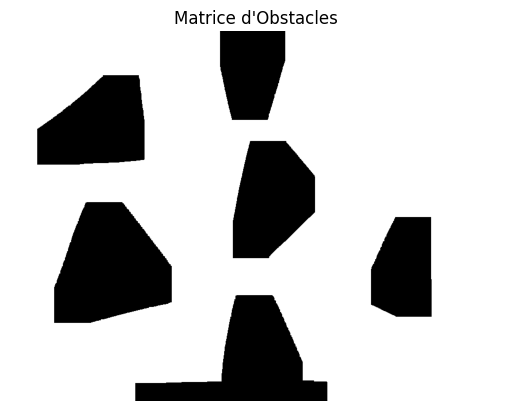

In [129]:
plt.imshow(global_obstacle, cmap='gray')
plt.title('Matrice d\'Obstacles')
plt.axis('off')
plt.show()
x, y, r = yellow_circles[0] #coordinate of the goal*********************************************************


"Initially, for the setup, it's advantageous to position the camera above the play area. This placement minimizes the need to account for perspective distortions. To accurately determine the robot's position and orientation, at least two distinct markers should be placed on the robot. These markers enable precise tracking and analysis of the robot's movements.

In [45]:


# Detect red and green circles
red_circles = detect_color_circle(image, lower_red_bound, upper_red_bound)
green_circles = detect_color_circle(image, lower_green_bound, upper_green_bound)
yellow_circles = detect_color_circle(image, lower_yellow_bound, upper_yellow_bound)

red_circles, green_circles, yellow_circles

NameError: name 'image' is not defined

In [ ]:


# Assuming red_circles and green_circles contain the detected circles for each color
# For demonstration, let's create dummy circle data
# red_circles = [(x1, y1, r1), (x2, y2, r2)]
# green_circles = [(x3, y3, r3)]

# TODO: Replace the dummy values with your actual circle centers and radii
#red_circles = [(50, 50, 30), (150, 50, 30)]  # Dummy values
#green_circles = [(100, 150, 30)]  # Dummy values

# Calculate the midpoint between the centers of the red circles
midpoint = ((red_circles[0][0] + red_circles[1][0]) // 2,
            (red_circles[0][1] + red_circles[1][1]) // 2)

# Draw a line (and arrow) from the green circle's center to the midpoint
cv2.arrowedLine(image,  green_circles[0][:2],midpoint, (0, 255, 0), 20)

# Calculate the angle of orientation with respect to the x-axis
dx = green_circles[0][0] - midpoint[0]
dy = green_circles[0][1] - midpoint[1]
angle = math.atan2(dy, dx)
angle_degrees = math.degrees(angle)

# Display the image with the drawn arrow
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'Angle of orientation: {angle_degrees:.2f} degrees')
plt.axis('off')
plt.show()

# Return the midpoint and the angle
midpoint, angle_degrees


For the obstacle detection: we used black shapes that we randomly distribute around the board. It is 

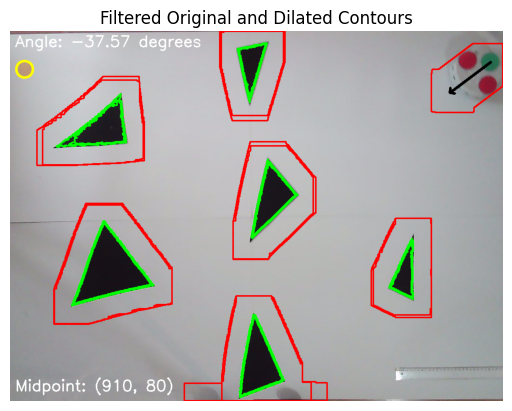

In [122]:

#image_path = 'WIN_20231124_15_09_52_Pro.jpg'
image = frame #cv2.imread(image_path)
image = frame.copy()  # Créer une copie de l'image
# Convert to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the lower and upper bounds for the black color
lower_black = np.array([0, 0, 0])
upper_black = np.array([180, 150, 40])

# Create a black color mask
mask_black = cv2.inRange(hsv, lower_black, upper_black)

# Find contours in the mask
contours, _ = cv2.findContours(mask_black, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Set a realistic threshold for the area of the contours
area_threshold = 2000  # Adjust this threshold according to your needs

# Filter the original contours that are larger than the threshold
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > area_threshold]

# Perform dilation to increase the size of the black regions
kernel_size = 70  # Kernel size can be adjusted to control the amount of dilation
kernel = np.ones((kernel_size, kernel_size), np.uint8)
mask_dilated = cv2.dilate(mask_black, kernel, iterations=1)

# Find contours in the dilated mask
dilated_contours, _ = cv2.findContours(mask_dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Filter the dilated contours that are larger than the threshold
filtered_dilated_contours = [cnt for cnt in dilated_contours if cv2.contourArea(cnt) > area_threshold]

# Draw the filtered original contours in green
for contour in filtered_contours:
    cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)

# Draw the filtered dilated contours in red
for contour in filtered_dilated_contours:
    cv2.drawContours(image, [contour], -1, (0, 0, 255), 2)

# Display the image with the drawn contours
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Filtered Original and Dilated Contours')
plt.axis('off')  # Hide the axis
plt.show()


# Tool functions that help with parameter tuning:
<a id="Vision-subsection-2"></a>


In [30]:


# Initialiser la capture vidéo
# '0' est généralement pour la webcam intégrée. Utilisez '1' ou d'autres numéros pour d'autres caméras.
video_capture = cv2.VideoCapture(1)

# Boucle pour la capture vidéo en continu
while True:
    # Capture frame par frame
    ret, frame = video_capture.read()

    # Si frame est lu correctement ret est True
    if not ret:
        print("Impossible de recevoir la frame (stream end?). Exiting ...")
        break

    # Afficher le frame capturé
    cv2.imshow('Video Stream', frame)

    # Rompre la boucle si 'q' est pressé
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Lorsque tout est terminé, libérer la capture
video_capture.release()
cv2.destroyAllWindows()


Impossible de recevoir la frame (stream end?). Exiting ...


In [4]:


# Initialisation de la capture vidéo (0 pour la caméra intégrée, 1 pour une caméra externe, etc.)
video_capture = cv2.VideoCapture(1)

# Capture une frame
ret, frame = video_capture.read()

# Libération de la ressource caméra
video_capture.release()

In [24]:
def plot_detected_circles(image, circles, circle_color):
    """
    Draws the detected circles on the image and plots it.

    :param image: The original image.
    :param circles: A list of circles with their coordinates and radius.
    :param circle_color: The color to use for drawing the circles.
    :return: None
    """
    if circles is not None and len(circles) > 0:
        for circle in circles:
            center = (circle[0], circle[1])  # Circle center
            radius = circle[2]  # Circle radius
            # Draw the circle's perimeter
            cv2.circle(image, center, radius, circle_color, 2)
            # Draw the circle's center
            cv2.circle(image, center, 2, circle_color, 3)

    # Plot the image with detected circles
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide the axis
    plt.show()


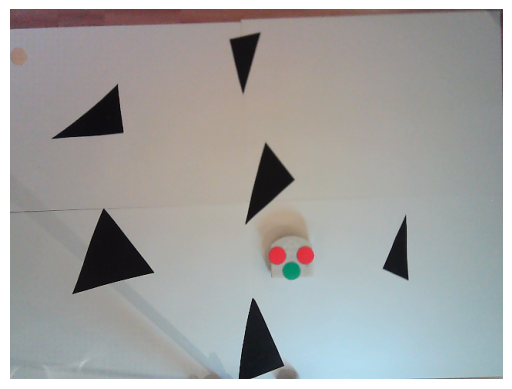

In [37]:


# Vérification si la frame a été capturée avec succès
if ret:
    # Conversion de l'image en RGB pour l'affichage avec Matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Affichage de l'image
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()
else:
    print("Erreur lors de la capture de l'image.")


In [38]:
# Obtenir les dimensions de l'image
h, w = frame_rgb.shape[:2]

# Calculer le nombre total de pixels
total_pixels = h * w

print(f"The image is of dimension {w}x{h} (width x hight)")
print(f"The total number of pixels is : {total_pixels}")




The image is of dimension 640x480 (width x hight)
The total number of pixels is : 307200


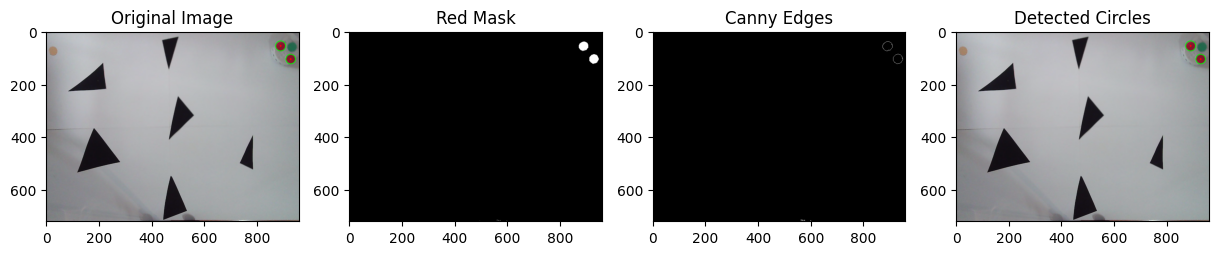

In [81]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
image = frame #cv2.imread('WIN_20231124_15_09_52_Pro.jpg')
image = image.copy()
# Convert to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the lower and upper bounds for the red color
# Note: Adjust these values according to your color calibration


# Create a red color mask
mask_red = cv2.inRange(hsv, lower_red_bound, upper_red_bound)

# Apply the mask to the image
red_only = cv2.bitwise_and(image, image, mask=mask_red)

# Convert the result to grayscale
gray = cv2.cvtColor(red_only, cv2.COLOR_BGR2GRAY)


# Apply Canny edge detection to help with circle detection
edges = cv2.Canny(gray, 100, 200)

# Detect circles using the Hough Transform
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 20,
                           param1=50, param2=20, minRadius=10, maxRadius=50)

# If circles are detected, draw them
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
        cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)

# Plotting the different stages
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(mask_red, cmap='gray')
plt.title('Red Mask')

plt.subplot(1, 4, 3)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')

plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Detected Circles')

plt.show()

In [82]:
import cv2
from matplotlib import pyplot as plt
from ipywidgets import interactive

def interactive_mask(lower_h, lower_s, lower_v, upper_h, upper_s, upper_v):
    lower_color_bound = np.array([lower_h, lower_s, lower_v])
    upper_color_bound = np.array([upper_h, upper_s, upper_v])
    
    mask = cv2.inRange(hsv, lower_color_bound, upper_color_bound)
    plt.imshow(mask, cmap='gray')
    plt.show()

# Assuming 'hsv' is your converted HSV image
interactive(interactive_mask, lower_h=(0,255), lower_s=(0,255), lower_v=(0,255),
            upper_h=(0,255), upper_s=(0,255), upper_v=(0,255))
#lower_red_bound = np.array([120, 70, 120])
#upper_red_bound = np.array([255, 255, 255])
#lower_green_bound = np.array([60, 120, 100])
#upper_green_bound = np.array([100, 255, 255])
#lower_black = np.array([0, 0, 0])
#upper_black = np.array([180, 255, 50])
#lower_yellow_bound = np.array([0, 60, 140])
#upper_yellow_bound = np.array([40, 105, 255])

interactive(children=(IntSlider(value=127, description='lower_h', max=255), IntSlider(value=127, description='…

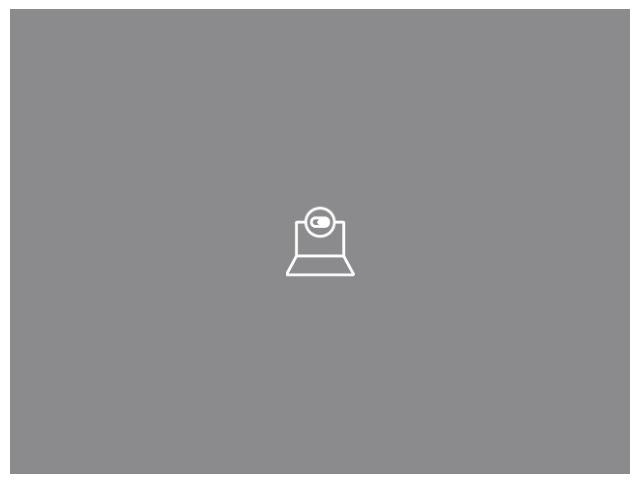

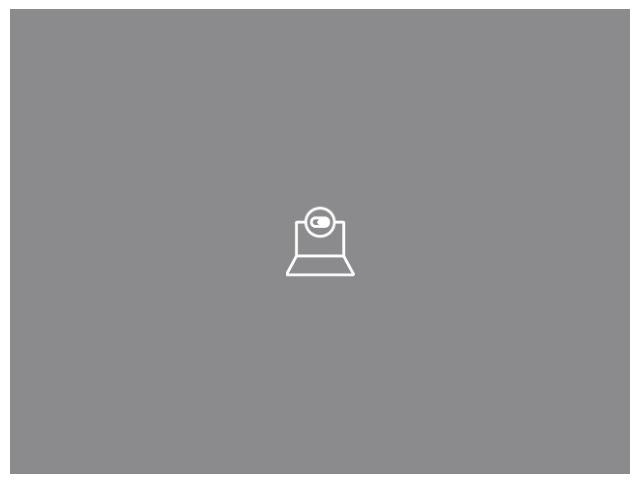

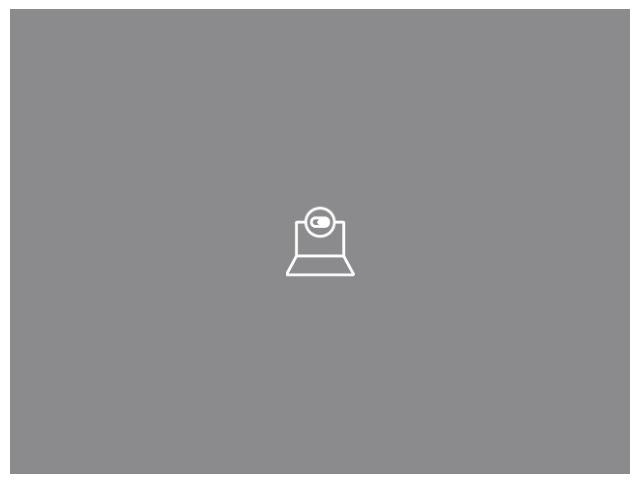

In [33]:
image = frame #cv2.imread('WIN_20231124_15_09_52_Pro.jpg')
red_circles = detect_color_circle(image, lower_red_bound, upper_red_bound)
green_circles = detect_color_circle(image, lower_green_bound, upper_green_bound)
yellow_circles = detect_color_circle(image, lower_yellow_bound, upper_yellow_bound)

red_circles, green_circles, yellow_circles

# Assuming red_circles and green_circles contain the detected circles for each color
image_copy = image.copy()  # Make a copy to draw on
plot_detected_circles(image_copy, red_circles, (200, 0, 255))  # Red color for red circles
plot_detected_circles(image_copy, green_circles, (0, 255, 0))  # Green color for green circles
plot_detected_circles(image_copy, yellow_circles,(255,255,153))  # yellow color for yellow circles


## 3 Global Navigation
<a id="global-navigation"></a>

## 4 Filtering
<a id="filtering"></a>

## 5 Local Navigation
<a id="local-navigation"></a>

## 6 Conclusion
<a id="conclusion"></a>